In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx
/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.1435 - val_loss: 0.3174 - learning_rate: 0.0010
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0218 - val_loss: 0.4120 - learning_rate: 0.0010
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0102 - val_loss: 0.1185 - learning_rate: 0.0010
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0055 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0043 - val_loss: 0.1052 - learning_rate: 0.0010
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0045 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0031 - val_loss: 8.9478e-04 - learning_rate: 0.0010
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0027 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 10/50
90/

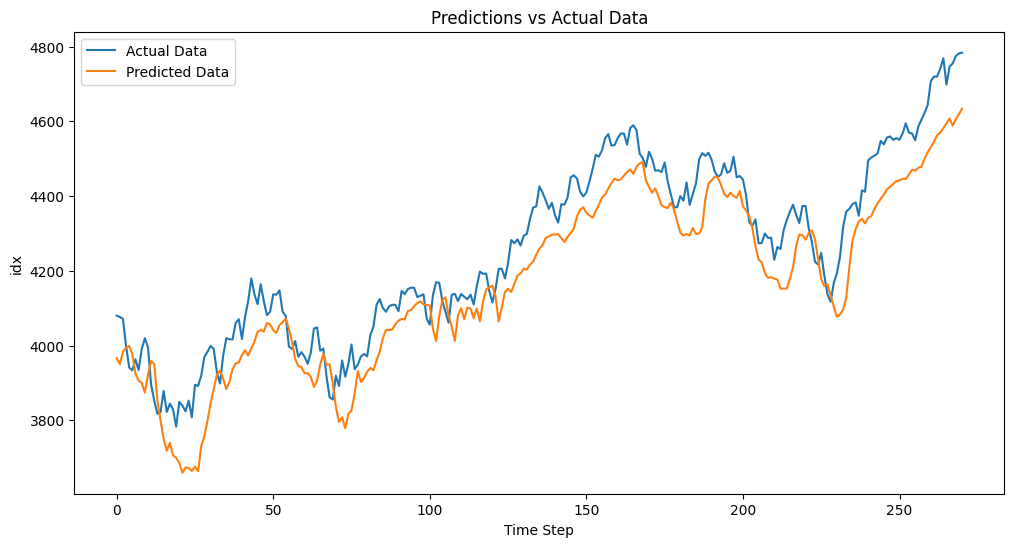

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model

# Load datasets
exogenous_data_path = '/kaggle/input/time-series-dataset/Exogenous_Data_1987_2024.xlsx'
training_data_path = '/kaggle/input/time-series-dataset/Training_Data_From_2000_To_2023 (1).xlsx'

exogenous_data = pd.read_excel(exogenous_data_path)
training_data = pd.read_excel(training_data_path)

# Drop 'Date' column and shift the target ('idx') by 1 day for correct prediction
data = training_data.drop('Date', axis=1)
data['idx'] = data['idx'].shift(-1)  # Shift 'idx' column by one day to predict the next day

# Drop the last row with NaN due to the shift
data = data.dropna()

# Normalize the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split the dataset (95% training, 5% testing)
train_size = int(len(data_scaled) * 0.95)
train, test = data_scaled[:train_size], data_scaled[train_size:]

# Create datasets for training and testing
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 1:])  # Input features (all except idx)
        y.append(dataset[i + time_step, 0])  # Target (idx column)
    return np.array(X), np.array(y)

# Set the time step (lookback window)
time_step = 30

# Create training and test datasets
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Define the LSTM-based model structure
def build_lstm_model(lstm_units, dropout_rate):
    num_features = X_train.shape[2]
    
    inputs = Input(shape=(time_step, num_features))

    # Increased LSTM layers and units for better learning
    x = LSTM(units=lstm_units, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(units=lstm_units, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LSTM(units=lstm_units)(x)
    x = BatchNormalization()(x)
    
    # Dropout layer
    x = Dropout(dropout_rate)(x)

    # Added Dense layers for improved learning
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    # Output layer
    outputs = Dense(1)(x)

    # Build and compile the model
    model = Model(inputs, outputs)
    return model

# Hyperparameters
lstm_units = 256  # Increased number of LSTM units
dropout_rate = 0.2  # Dropout rate remains same
learning_rate = 1e-3  # Increased learning rate for faster learning
epochs = 50  # Increased the number of epochs to allow more learning
batch_size = 64  # Keep batch size the same

# Build the LSTM model
model = build_lstm_model(lstm_units, dropout_rate)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Fit the model with more epochs
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)

# After training, make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1))], axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))], axis=1))[:, 0]

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
train_mae = mean_absolute_error(y_train, train_predict)
test_mae = mean_absolute_error(y_test, test_predict)
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)

# Print performance metrics
print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train R2: {train_r2}, Test R2: {test_r2}')

# Plot predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Data')
plt.plot(test_predict, label='Predicted Data')
plt.title('Predictions vs Actual Data')
plt.xlabel('Time Step')
plt.ylabel('idx')
plt.legend()
plt.show()
